# **CNN Encoder Decoder SE Block with COCO dataset**

In the present computational notebook, we have executed the implementation of a convolutional autoencoder that incorporates a Squeeze-and-Excitation (SE) block nestled between the encoder and decoder modules. This strategic integration of the SE block is aimed at 

amplifying the model's performance through discerning and accentuating the most pertinent filters for the task of color reconstruction.

This design adaptation originates from a deliberate focus on the coloring reconstruction task, which is primarily rooted in our dataset that comprises of various facial images. The dataset has been meticulously utilized for both the training and testing processes, offering a comprehensive and relevant knowledge base for the model to learn from. 

The main imporvement we present in this notebook is that we separated the channels of LAB colorspace and using the L channel as input, so the network only have to reconstruct 2 channels, the A,B ones. This dramatically reduces the possible numbers that the model have to predict, acomplishing a much fast training and good performance. 

For more in-depth understanding and technical insights about Squeeze-and-Excitation Networks, readers are referred to the scholarly work by Hu et al., titled "Squeeze-and-Excitation Networks", presented at the Computer Vision and Pattern Recognition (CVPR) conference in 2018.

For the training of this model we use the COCO validation part, that has 5000 images. The use of this reduced dataset if for the seek of simplicity and reasonable training time.

# Import necessary libraries

In [ ]:
import random
import matplotlib.pyplot as plt
import zipfile
import io
from google.colab import files#This line shoul be commented if you are not using a google colab as environment to execute the program
import torchvision
from torch import nn
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import cv2
from skimage import color
import requests
import torchvision.transforms.functional as TF

# Connect to GPU if availble 

*Clear the CUDA memory cache. This releases all unoccupied cached memory so that those can be used by CUDA operations if necessary. This can help prevent the CUDA out-of-memory errors that can occur when the memory is filled up with cached, but unused data.*

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "tpu")

# Utils

*Request the COCO dataset and create different folders to split the data into train and test.*

In [ ]:
url = "http://images.cocodataset.org/zips/val2017.zip"  # Replace with the URL of the dataset file
save_path = "dataset.zip"  # Replace with the desired save path

response = requests.get(url)
with open(save_path, "wb") as f:
    f.write(response.content)

In [ ]:
# Specify the file name of the uploaded ZIP file
zip_filename = "DeepColorization-master.zip"

# Extract the contents of the ZIP file
with zipfile.ZipFile(save_path, "r") as zip_ref:
    zip_ref.extractall("face_images")

In [ ]:
# Path to the extracted dataset folder
dataset_folder_path = "face_images/val2017"

# Get the list of image files in the dataset folder
image_files = [f for f in os.listdir(dataset_folder_path) if os.path.isfile(os.path.join(dataset_folder_path, f))]

In [ ]:
# Create directories for training and validation sets
train_folder = "dataset/train"
val_folder = "dataset/val"

# Create the directories if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

In [ ]:
# Shuffle the image files list
random.shuffle(image_files)

# Determine the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8
split_index = int(len(image_files) * split_ratio)

# Split the image files list into training and validation sets
train_image_files = image_files[:split_index]
val_image_files = image_files[split_index:]

In [ ]:
# Iterate through the training set image files
for i, image_name in enumerate(train_image_files):
    image_path = os.path.join(dataset_folder_path, image_name)
    image = Image.open(image_path)

    colored_image_path = os.path.join(train_folder, image_name)
    image.save(colored_image_path)

In [ ]:
# Iterate through the validation set image files
for image_name in val_image_files:
    image_path = os.path.join(dataset_folder_path, image_name)
    image = Image.open(image_path)

    # Save the colored image in the validation folder
    colored_image_path = os.path.join(val_folder, image_name)
    image.save(colored_image_path)

# LAB Colourspace

*Design and implement a class to facilitate the application of essential image transformations. The key advancement of this methodology resides in the precise specification of input and output parameters, which is determined within this particular cell.*

*In this model, the image is partitioned into the respective L, A, and B channels of the LAB color space. This partitioning enables the utilization of the L channel (representing grayscale) as input, while the A and B color channels serve as output. This approach effectively reduces the number of predicted values for each image, thereby simplifying and expediting the training process.*

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Initialize the ColorizationDataset class with the specified root directory and transformation
        self.root_dir = root_dir
        self.transform = transform
        # Get a list of image files in the root directory
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        # Return the length of the dataset (number of image files)
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image at the specified index
        image_name = self.image_files[idx]
        image_path = os.path.join(self.root_dir, image_name)
        # Open the image using PIL
        image = Image.open(image_path)
        # Apply the specified transformation to the image
        image = self.transform(image)
        # Transpose the image tensor
        image = torch.transpose(image, dim0=0, dim1=2)
        # Convert the image to LAB color space
        if image.size(-1) == 3:
            lab_image = color.rgb2lab(image.numpy())
        else:
            lab_image = new_tensor = torch.zeros((128,128,3))

        lab_image = torch.tensor(lab_image)
        # Extract the L channel
        L_channel = torch.transpose(lab_image[:,:,0], dim0=1, dim1=0)
        L_channel = L_channel.unsqueeze(0)
        # Extract the AB channels
        AB_channel = torch.transpose(lab_image[:,:,1:], dim0=2, dim1=0)

        return L_channel, AB_channel

In [ ]:
# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
   
    
])
# Define the path to your dataset directory
dataset_root = "dataset/"

# Create an instance of the custom dataset
train_dataset = ColorizationDataset(os.path.join(dataset_root, "train"), transform=transform)

#Instance of the custom validation dataset
test_dataset = ColorizationDataset(os.path.join(dataset_root, "val"), transform=transform)

# Define the batch size for the DataLoader
batch_size = 256

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the DataLoader for validation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model

*Define the architecture of the model.*

**Normal size architecture**

In [ ]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)  # b, 16, 64, 64
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  # b, 32, 32, 32
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # b, 64, 16, 16

        self.pooling = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 64)

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)  # b, 32, 32, 32
        self.deconv2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)  # b, 16, 64, 64
        self.deconv3 = nn.ConvTranspose2d(16, 2, 3, stride=2, padding=1, output_padding=1)  # b, 2, 128, 128

    def encoder(self, x):
        # Encoding layers with ReLU activation
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)

        return x

    def attention(self, x):
        batch_size, channels, height, width = x.size()

        # Squeeze (global average pooling)
        squeeze = self.pooling(x).view(batch_size, channels)

        # Excitation (fully connected layers)
        excitation = torch.nn.functional.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation))

        # Re-calibration
        excitation = excitation.view(batch_size, channels, 1, 1)
        scaled_feature = x * excitation.expand_as(x)

        return scaled_feature

    def decoder(self, x):
        # Decoding layers with ReLU activation
        x = self.deconv1(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv2(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv3(x)

        x = x.float()

        return x

    def forward(self, x):
        # Forward pass through the network
        encoded = self.encoder(x)
        att = self.attention(encoded)
        decoded = self.decoder(att)

        return decoded

**Big size model**

*Although initially anticipated to yield superior performance on the COCO dataset due to its higher complexity, the aforementioned model encountered overfitting issues during training. Consequently, for the results presented in this notebook, the decision was made to employ the Normal size model instead.*

In [ ]:
class BigConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()

        # Define the convolutional layers for encoding
        self.conv1 = nn.Conv2d(1, 4, 3, stride=2, padding=5)  # b, 4, 68, 68
        self.conv2 = nn.Conv2d(4, 8, 3, stride=2, padding=5)  # b, 8, 38, 38
        self.conv3 = nn.Conv2d(8, 16, 3, stride=2, padding=2)  # b, 16, 20, 20
        self.conv4 = nn.Conv2d(16, 32, 5, stride=1, padding=0)  # b, 32, 16, 16
        self.conv5 = nn.Conv2d(32, 48, 5, stride=1, padding=0)  # b, 48, 12, 12
        self.conv6 = nn.Conv2d(48, 64, 3, stride=1, padding=0)  # b, 64, 10, 10
        self.conv7 = nn.Conv2d(64, 84, 3, stride=1, padding=0)  # b, 84, 8, 8

        self.pooling = nn.AdaptiveAvgPool2d((1,1))

        # Define the fully connected layers for attention
        self.fc1 = nn.Linear(84, 16)
        self.fc2 = nn.Linear(16, 84)

        # Define the transpose convolutional layers for decoding
        self.deconv1 = nn.ConvTranspose2d(84, 64, 5, stride=1, padding=0, output_padding=0)  # b, 64,12 , 12
        self.deconv2 = nn.ConvTranspose2d(64, 48, 3, stride=2, padding=0, output_padding=0)  # b, 48, 27, 27
        self.deconv3 = nn.ConvTranspose2d(48, 32, 3, stride=1, padding=0, output_padding=0)  # b, 32, 30, 30
        self.deconv4 = nn.ConvTranspose2d(32, 16, 5, stride=2, padding=0, output_padding=0)  # b, 16, 65, 65
        self.deconv5 = nn.ConvTranspose2d(16, 8, 5, stride=1, padding=0, output_padding=0)  # b, 8, 68, 68
        self.deconv6 = nn.ConvTranspose2d(8, 6, 5, stride=2, padding=0, output_padding=0)  # b, 3, 128, 128
        self.deconv7 = nn.ConvTranspose2d(6, 2, 4, stride=1, padding=0, output_padding=0)  # b, 3, 128, 128

    def encoder(self, x):
        """
        Encoding layers with ReLU activation
        """
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        x = self.conv5(x)
        x = torch.nn.functional.relu(x)
        x = self.conv6(x)
        x = torch.nn.functional.relu(x)
        x = self.conv7(x)
        x = torch.nn.functional.relu(x)

        return x

    def attention(self, x):
        """
        Attention mechanism for recalibration
        """
        batch_size, channels, height, width = x.size()

        # Squeeze (global average pooling)
        squeeze = self.pooling(x).view(batch_size, channels)

        # Excitation (fully connected layers)
        excitation = torch.nn.functional.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation))

        # Re-calibration
        excitation = excitation.view(batch_size, channels, 1, 1)
        scaled_feature = x * excitation.expand_as(x)

        return scaled_feature

    def decoder(self, x):
        """
        Decoding layers with ReLU activation
        """
        x = self.deconv1(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv2(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv3(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv4(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv5(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv6(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv7(x)

        return x

    def forward(self, x):
        """
        Forward pass through the network
        """
        encoded = self.encoder(x)
        att = self.attention(encoded)
        decoded = self.decoder(att)

        return decoded

*Create an instance of the model and define the optimizer and criterion to use.*

In [ ]:
# Instance of the model
model = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

# mean-squared error loss
criterion = nn.MSELoss()

# Training and Validation

*Define the training and test steps.*

In [ ]:
# Define a function to train the model
def train(model, loader, optimizer, criterion, reshape=False):
    # Initialize the loss to 0
    loss = 0
    # Set the model to training mode
    model.train()

    # Iterate over all batches in the loader
    for batch_features, feat in loader:
        # Move the batch features and labels to the device the model is running on
        batch_features = batch_features.to(device)
        feat = feat.to(device)

        # Optionally reshape the batch features from [N, C, H, W] to [N, 784] 
        if reshape:
            batch_features = batch_features.view(-1, 784)
        
        # Reset the gradients in the optimizer
        optimizer.zero_grad()
        
        # Forward propagate the batch through the model
        outputs = model(batch_features)
        
        # Compute the loss between the model output and actual labels
        train_loss = criterion(outputs, feat)
        
        # Backward propagate the loss through the model
        train_loss.backward()
        
        # Perform a step of optimization
        optimizer.step()
        
        # Add the batch loss to the total loss for the epoch
        loss += train_loss.item()

    # Compute the average epoch loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))
    return loss

# Define a function to test the model
def test(model, loader, criterion, reshape=False):
    # Initialize the loss to 0
    loss = 0
    # Set the model to evaluation mode
    model.eval()
    
    # Iterate over all batches in the loader
    for batch_features, feat in loader:
        # Move the batch features and labels to the device the model is running on
        batch_features = batch_features.to(device)
        feat = feat.to(device)
        
        # Optionally reshape the batch features from [N, C, H, W] to [N, 784] 
        if reshape:
            batch_features = batch_features.view(-1, 784)

        # Wrap the forward pass in torch.no_grad to save memory during testing
        with torch.no_grad():
            # Forward propagate the batch through the model
            outputs = model(batch_features)
        
        # Compute the loss between the model output and actual labels
        test_loss = criterion(outputs,feat)
 
        # Add the batch loss to the total loss for the epoch
        loss += test_loss.item()
    
    # Compute the average epoch loss
    loss = loss / len(loader)
    
    # Display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    
    
    return loss

*Run the training and test.*

In [ ]:

# Determine if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the number of epochs for training
epochs = 10

# Initialize lists to store loss values for each epoch
train_loss_list = []
test_loss_list = []

# Training loop 
for epoch in range(epochs):
    # Train the model on the training data and get the training loss
    train_loss = train(model, train_loader, optimizer, criterion, reshape=False)
    
    # Test the model on the testing data and get the testing loss
    test_loss = test(model, test_loader, criterion, reshape=False)

    # Append the training and testing loss for this epoch to their respective lists
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

# Plotting the loss curve

# Plot the training loss over epochs
plt.plot(train_loss_list, label='Train Loss')

# Plot the testing loss over epochs
plt.plot(test_loss_list, label='Test Loss')

# Label the x-axis as 'Epochs'
plt.xlabel('Epochs')

# Label the y-axis as 'Loss'
plt.ylabel('Loss')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Results with test

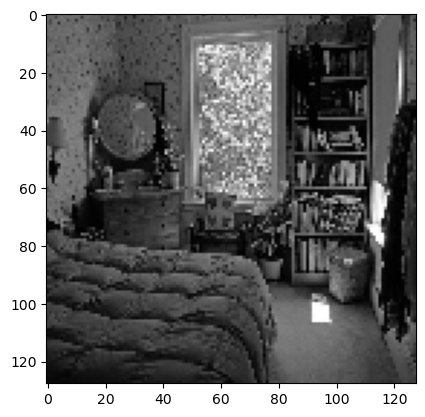

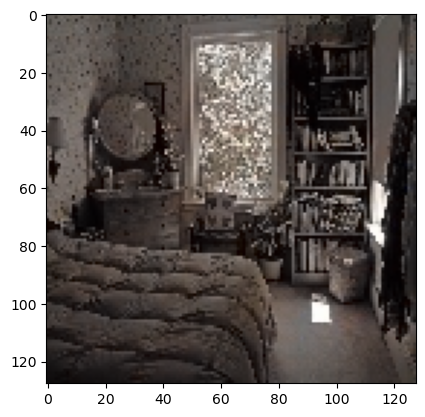

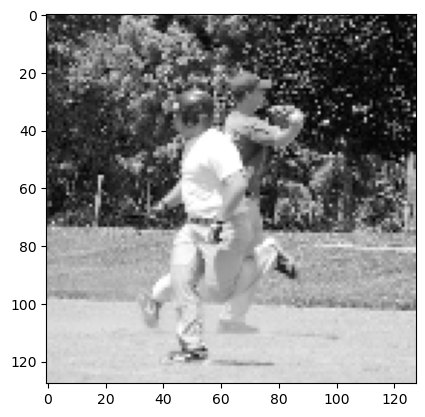

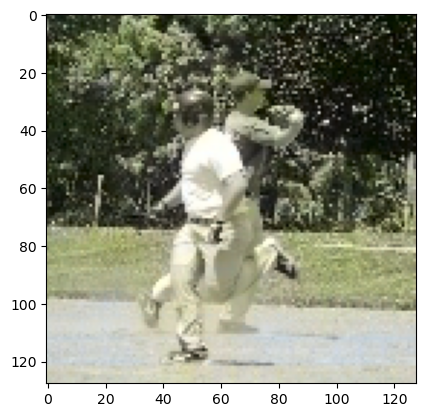

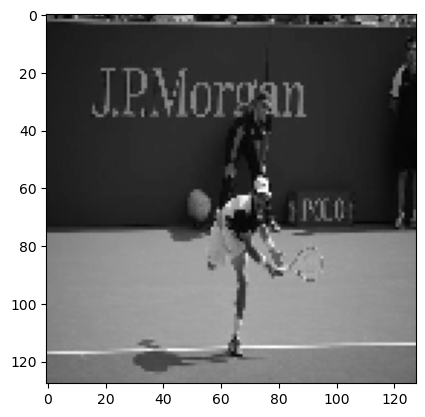

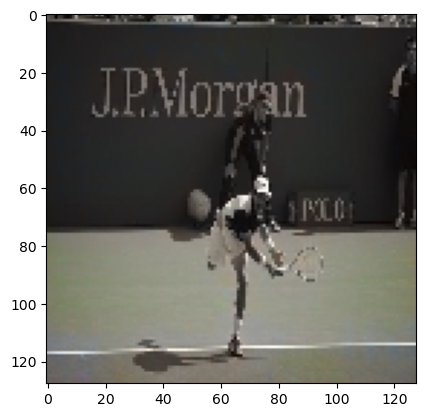

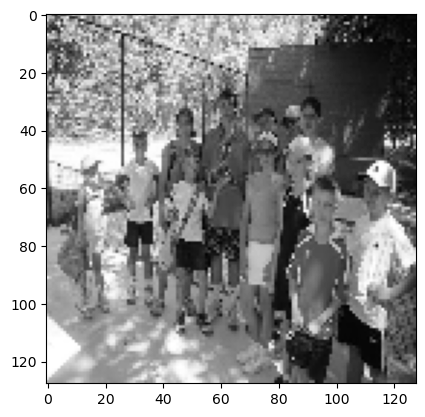

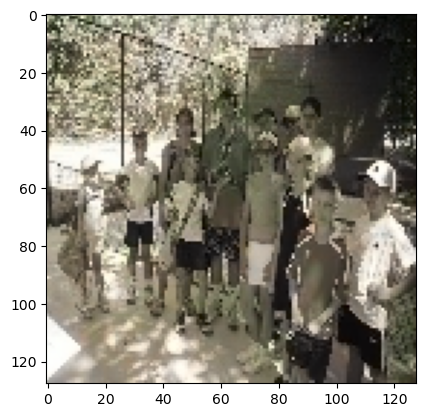

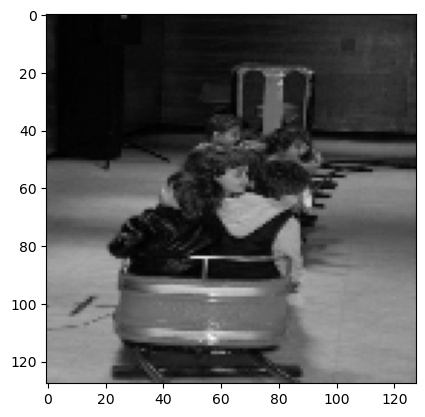

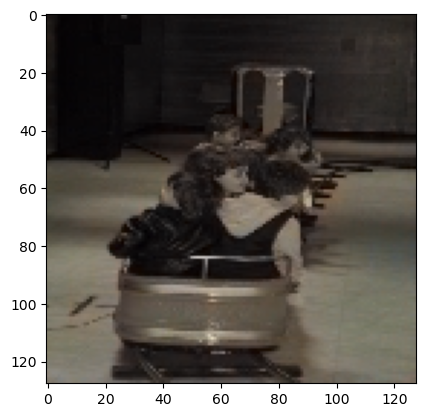

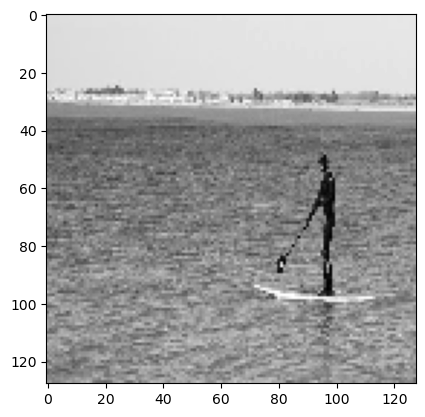

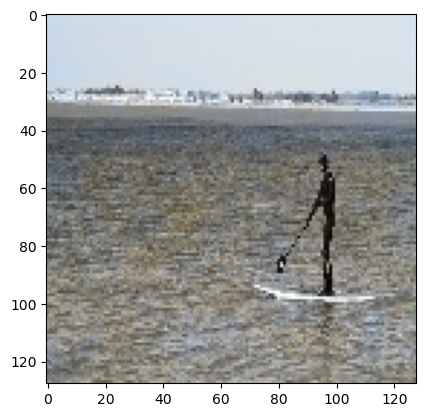

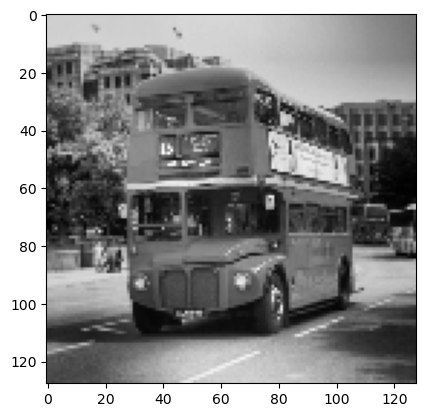

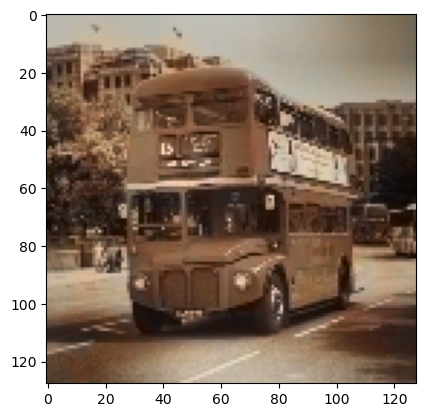

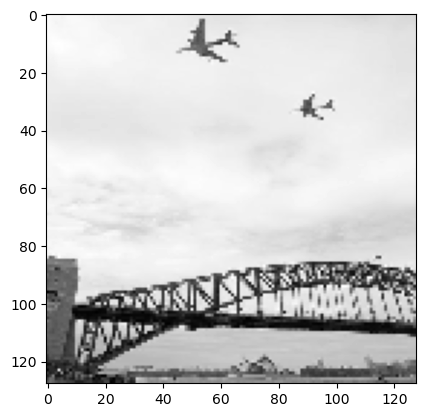

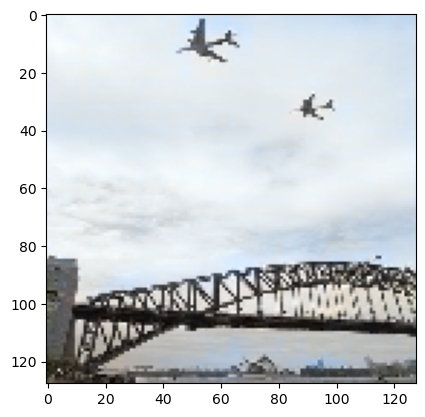

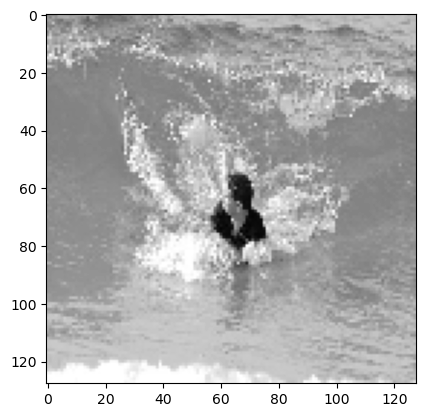

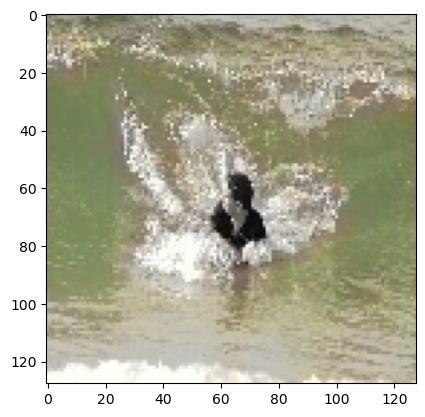

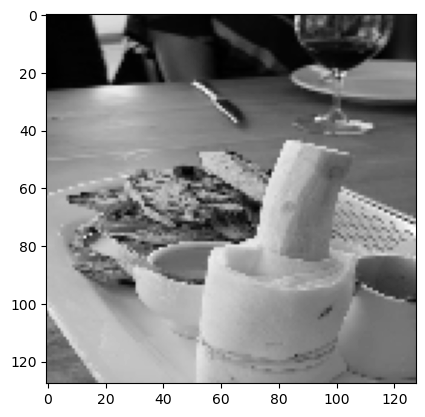

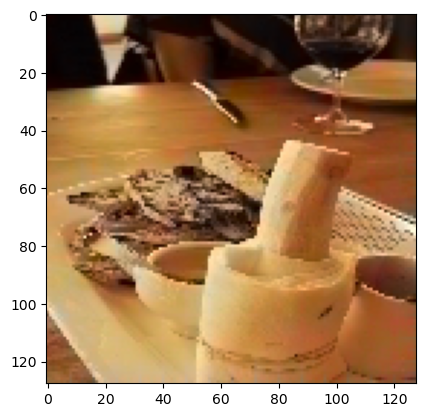

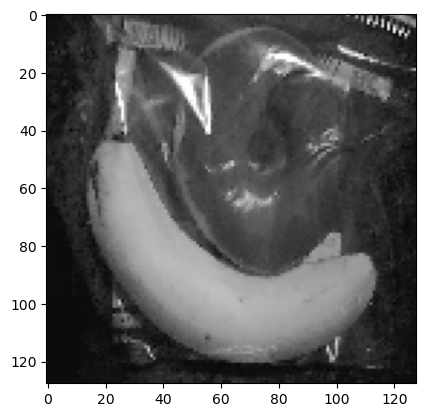

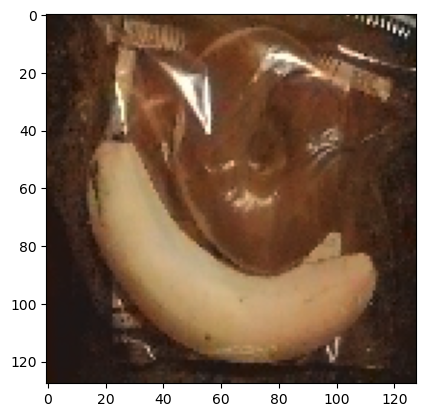

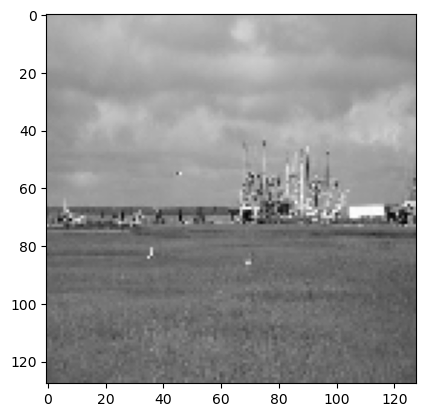

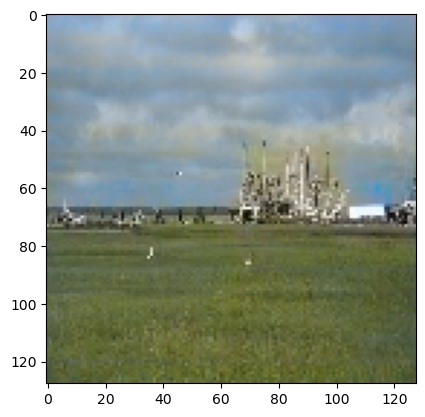

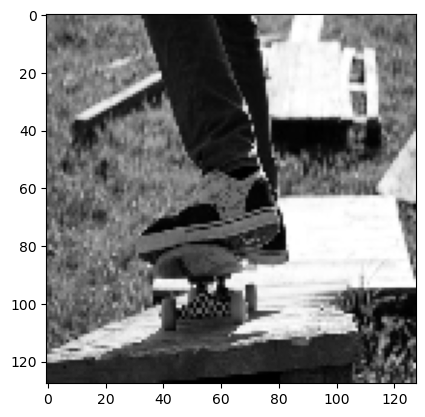

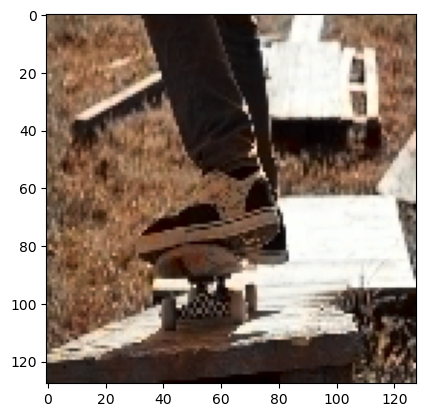

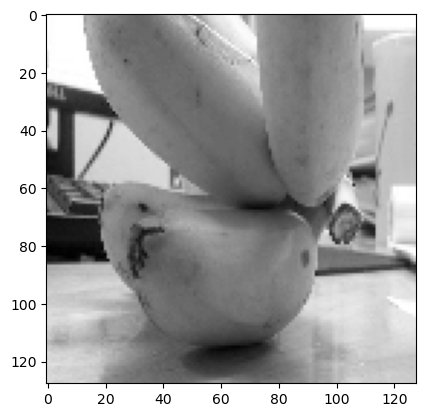

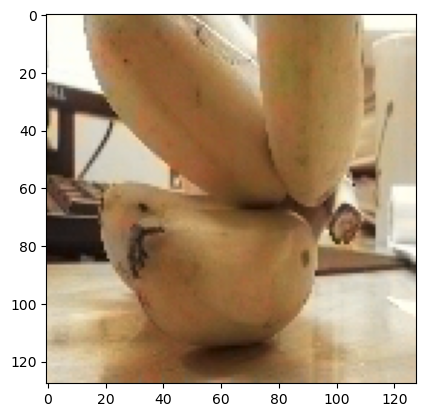

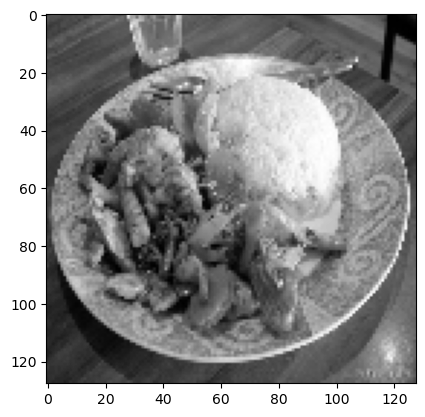

C:\Users\10psa\AppData\Local\Temp\ipykernel_5324\427641893.py:44: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(merged_lab_image.numpy())


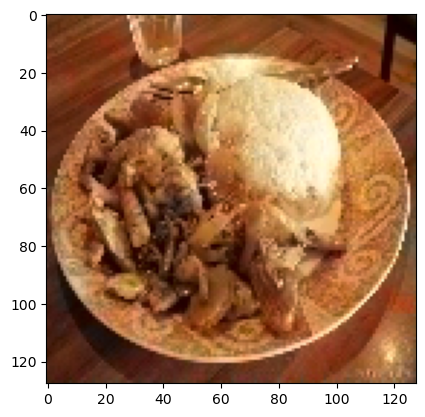

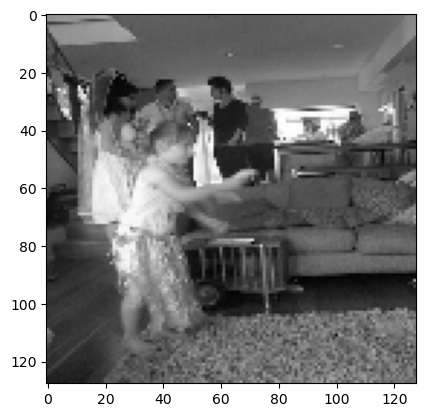

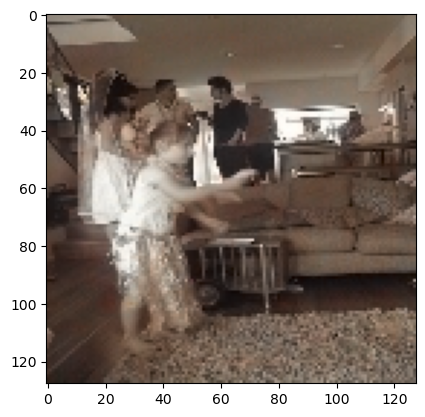

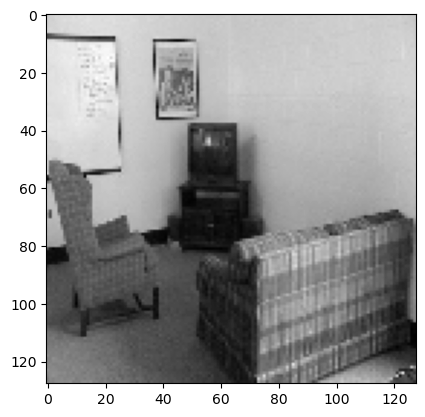

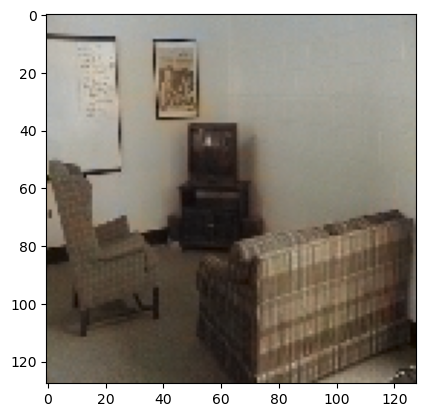

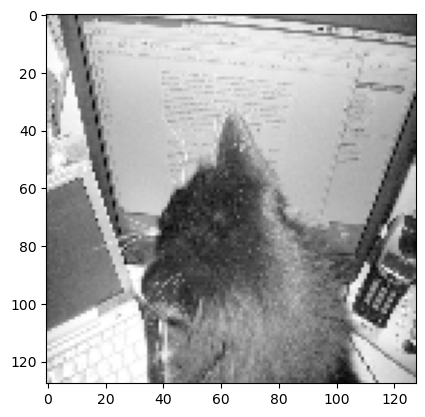

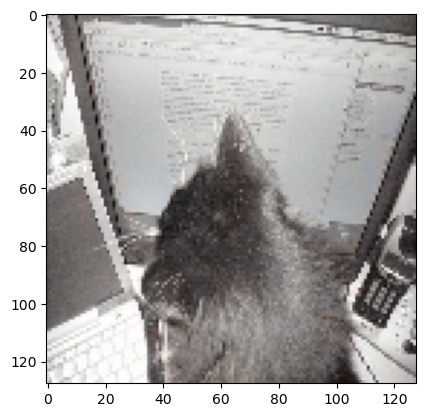

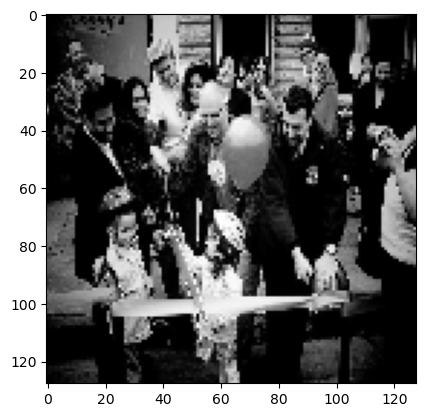

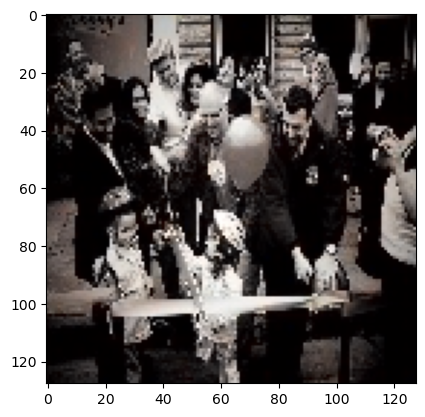

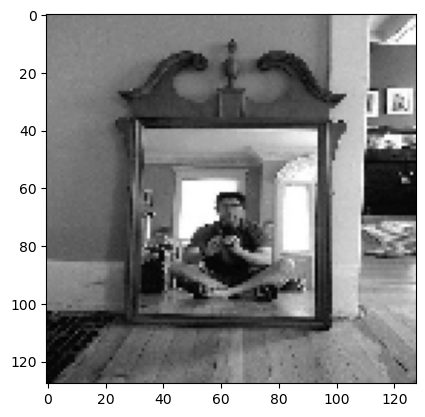

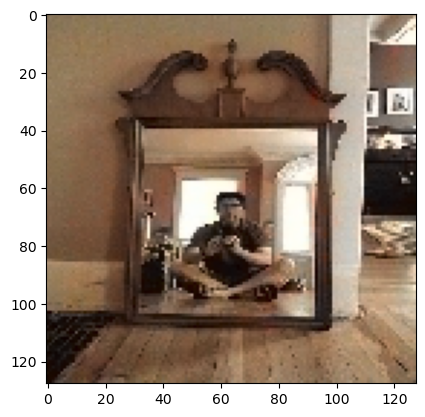

C:\Users\10psa\AppData\Local\Temp\ipykernel_5324\1044592082.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lab_image = torch.tensor(lab_image)


In [ ]:
# Set the model to evaluation mode
model.eval()

test_images = 20  # Specify how many images of the test set to show

for i, image_name in enumerate(test_dataset):
    if i < test_images:
        # Get the grayscale image from the dataset
        gray_image_u = image_name[0].squeeze(0)
        
        # Display the grayscale image
        plt.imshow(gray_image_u, cmap="gray")
        plt.show()

        # Preprocess the grayscale image
        gray_image = image_name[0].unsqueeze(0).to(device)

        # Pass the grayscale image through the model to obtain the reconstructed colored image
        with torch.no_grad():
            colored_image = model(gray_image)

        # Convert the output tensor to an RGB image
        colored_image = colored_image.cpu()
        colored_image = colored_image.squeeze(0)
        Ap_channel = colored_image[0, :, :]
        Bp_channel = colored_image[1, :, :]
        merged_lab_image = torch.stack((gray_image_u, Ap_channel, Bp_channel), axis=2)
        rgb_image = color.lab2rgb(merged_lab_image.numpy())
        
        # Display the reconstructed colored image
        plt.imshow(rgb_image)
        plt.show()

#Save the weights of the model

*Save the weights of the model for posterior use without the need of training.*

In [ ]:
torch.save(model.state_dict(), 'ColoringAutoencoder1000')